In [1]:
!pip install bertopic
import pandas as pd
import re
import nltk
from bertopic import BERTopic
import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 623.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.7 MB/s eta 0:00:0000:01:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 95.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 113.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 61.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 45.2 MB/s eta 0:00:0000:0100:01
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-linux_x86_64.whl size=35841

## Data

In [2]:
df_kickstarter = pd.read_csv('./kickstarter_cleaned.csv')

# Functions

In [ ]:
# Usage optional -> probably better embeddings without this
def preprocess_text(document: str) -> str:

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Converting to Lowercase
    document = document.lower()

    return document;

# BERTopic

In [3]:
# Copy Dataframe
df_bertopic_kickstarter = df_kickstarter.copy()

In [ ]:
# Remove the columns
#df_bertopic_kickstarter.drop(df_bertopic_kickstarter.columns.difference(['project_description', 'project_category_id', 'project_parent_category_id', 'project_state', 'project_launched_at']), axis=1,inplace=True)

## Technology Category

In [4]:
df_bertopic_kickstarter_technology = df_bertopic_kickstarter.copy()

In [5]:
# Filter Dataframe by Technology category (number 16)
df_bertopic_kickstarter_technology = df_bertopic_kickstarter_technology[(df_bertopic_kickstarter_technology['project_category_id'] == 16) | (df_bertopic_kickstarter_technology['project_parent_category_id'] == 16)]

In [6]:
docs_technology = df_bertopic_kickstarter_technology['project_description'].tolist()

In [7]:
from sentence_transformers import SentenceTransformer

# all-distilroberta-v1 512 token limit default is all-MiniLM-L6-v2 with 256 token limit
sentence_model = SentenceTransformer("all-distilroberta-v1")
embeddings_technology = sentence_model.encode(docs_technology, show_progress_bar=True)

Batches:   0%|          | 0/802 [00:00<?, ?it/s]

In [8]:
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# Only Topics with 40 documents or more
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# removes noise
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=(['0000', 'with sound', 'play replay', 'replay with', 'capable browser', 'sound 0000', 'html5 capable', 'content play', '0000 0000', 'sound play']))

# removes stopwords and other extremes
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # vectorizer_model = CountVectorizer(stop_words="english") as an alternative to remove stopwords (does not remove other extremes)

topic_model_technology = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, language="english", calculate_probabilities=True, verbose=True, n_gram_range=(1, 2)) #embedding_model=sentence_model
topics_technology, probs_technology = topic_model_technology.fit_transform(docs_technology, embeddings_technology) #add embeddings as parameter to use costum embeddings model

2023-09-28 03:08:20,182 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-28 03:08:28,729 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model_technology.save("./Bertopic_technology")

In [9]:
freq = topic_model_technology.get_topic_info(); freq.head(11)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,10501,-1_app_will_be_their,"[app, will, be, their, have, this, are, will b...",[We got the right dock for your Apple Watch an...
1,0,1050,0_audio_music_sound_guitar,"[audio, music, sound, guitar, headphones, spea...",[Acoustas Melody-G Acoustas Melody-G Set...
2,1,878,1_charging_charge_charger_power,"[charging, charge, charger, power, battery, us...",[*Please note that we've send out an early pro...
3,2,524,2_fitness_workout_training_exercise,"[fitness, workout, training, exercise, workout...",[The Juve is an innovative way for women to ex...
4,3,443,3_students_student_college_teachers,"[students, student, college, teachers, math, s...",[We couldn't be more excited about reaching ou...
5,4,410,4_3d_printer_printing_print,"[3d, printer, printing, print, 3d printer, pri...","[WHY ARE WE DOING THIS?In short, our Gear-Driv..."
6,5,406,5_light_led_lighting_lights,"[light, led, lighting, lights, leds, flashligh...",[Tired of tripping over things in the dark at ...
7,6,387,6_energy_solar_wind_turbine,"[energy, solar, wind, turbine, electricity, ge...",[THE GORDONATOR MIGHT BE THE MOST IMPORTANT PR...
8,7,353,7_camera_gopro_cameras_lens,"[camera, gopro, cameras, lens, mount, tripod, ...",[ Radian connects to your camera via the USB o...
9,8,331,8_police_emergency_law enforcement_911,"[police, emergency, law enforcement, 911, enfo...",[Virtual Halo is an exciting new app that's be...


In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs_technology, hide_document_hover=True, hide_annotations=True, embeddings = embeddings)

### Dynamic Topic Modelling

In [ ]:
topic_model = BERTopic.load("./Bertopic_technology")

In [ ]:
from datetime import datetime

In [ ]:
timestamps  = pd.to_datetime(df_bertopic_kickstarter_technology['project_launched_at']).apply(lambda x: (datetime.timestamp(x))).tolist()

In [ ]:
timestamps_month = pd.to_datetime(df_bertopic_kickstarter_technology['project_launched_at']).dt.strftime('%Y-%m').tolist()

In [ ]:
topics_over_time = topic_model.topics_over_time(docs_technology, timestamps_month, nr_bins=20)

20it [41:32, 124.64s/it]


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[55, 64, 65])

In [ ]:
topics_over_time.head(5)

,Topic,Words,Frequency,Timestamp,Name
0,-1,"muralizer, greenlighted, dye, public collectio...",25,2009-04-25 22:45:07.200,-1_app_will_be_this
1,4,"mikai, screenplay, their reading, reading know...",2,2009-04-25 22:45:07.200,4_students_student_college_teachers
2,5,"back off, sunset and, turn back, lights, house...",1,2009-04-25 22:45:07.200,5_light_led_lighting_lights
3,6,"jeremy dean, the ministry, futurama, the eu, m...",4,2009-04-25 22:45:07.200,6_energy_solar_wind_turbine
4,11,"nevir, nevir spies, spies, traditional email, ...",1,2009-04-25 22:45:07.200,11_security_password_data_passwords


In [ ]:
topics_over_time.to_csv('./topics_over_time.csv')

In [ ]:
topics_over_time.to_csv('./topics_over_time_months.csv')

### Difference in Relative topic prevelance

In [ ]:
def assign_topic_dist(df, probs):
    df['topic_dist'] = None 
    for i, dist in enumerate(probs):
        df.at[df.index[i], "topic_dist"] = dist.tolist()

In [ ]:
def calculate_relative_topic_prevelances_per_year(df):

    # Initialize a new DataFrame to store the results
    topic_df = pd.DataFrame(columns=['year'])

    # Get unique years
    unique_years = df['year'].unique()

    # Get number of topics
    topics = df['topic'].unique()
    num_topics = len(topics) - 1 #outliers in topic -1

    # Iterate over unique years and perform operations
    for year in unique_years:
        # Filter data for the current year and topic not equal to -1
        year_data = df[(df['year'] == year) & (df['topic'] != -1)]

        # Sum up topic probabilities and calculate mean for each topic
        topic_occurances = {i: 0 for i in range(num_topics)}
        for topic in year_data['topic']:
            topic_occurances[topic] += 1

        # stores the mean probability of each topic across all documents, weighted by the probability of that topic in each document
        topic_means = {topic: topic_occurances[topic] / len(year_data.index) for topic in topic_occurances}

        # Create a dictionary with year and topic mean probabilities
        topic_means['year'] = year

        # Append the calculated means for the current year to the result DataFrame
        topic_df = topic_df.append(topic_means, ignore_index=True)

    return topic_df

In [ ]:
def calculate_relative_weighted_topic_prevelances_per_year(df):

    # Initialize a new DataFrame to store the results
    topic_df = pd.DataFrame(columns=['year'])

    # Get unique years
    unique_years = df['year'].unique()

    # Get number of topics
    topics = df['topic'].unique()
    num_topics = len(topics) - 1 #outliers in topic -1

    # Iterate over unique years and perform operations
    for year in unique_years:
        # Filter data for the current year and topic not equal to -1
        year_data = df[(df['year'] == year) & (df['topic'] != -1)]

        # Sum up topic probabilities and calculate mean for each topic
        topic_prob_sums = {i: 0 for i in range(num_topics)}
        for dist in year_data['topic_dist']:
            for i, prob in enumerate(dist):
                topic_prob_sums[i] += prob

        # stores the mean probability of each topic across all documents, weighted by the probability of that topic in each document
        topic_means_weighted = {topic: topic_prob_sums[topic] / len(year_data.index) for topic in topic_prob_sums}

        # Create a dictionary with year and topic mean probabilities
        topic_means_weighted['year'] = year

        # Append the calculated means for the current year to the result DataFrame
        topic_df = topic_df.append(topic_means_weighted, ignore_index=True)

    return topic_df

In [ ]:
def calculate_difference_average_topic_prevelance(df, df_topic):

    # Initialize a new column to store the differences
    df['difference_average_topic_prevalence'] = 0.0

    # Iterate over rows using iterrows
    for index, row in df.iterrows():
        year = int(row['year'])
        topic = row['topic']
        if(year == 2009):
            continue
        if(topic == -1):
            continue
        else:
            topics_current_year = df_topic[df_topic['year'] == str(year)]
            topics_last_year = df_topic[df_topic['year'] == str(year - 1)]
            df.at[index, 'difference_average_topic_prevalence'] = topics_current_year[topic].values[0] - topics_last_year[topic].values[0]

In [ ]:
def calculate_difference_average_topic_prevelance_weighted(df, df_topic):

    # Initialize a new column to store the differences
    df['difference_average_topic_prevalence'] = 0.0

    # Iterate over rows using iterrows
    for index, row in df.iterrows():
        year = int(row['year'])
        topic = row['topic']
        if(year == 2009):
            continue
        if(topic == -1):
            continue
        else:
            topic_dist = row['topic_dist']
            topics_current_year = df_topic[df_topic['year'] == str(year)]
            topics_last_year = df_topic[df_topic['year'] == str(year - 1)]
            for i, prob in enumerate(topic_dist):
                # Calculate the difference in average topic prevalence for each topic in the distribution
                diff = prob * (topics_current_year[i].values[0] - topics_last_year[i].values[0])
                df.at[index, 'difference_average_topic_prevalence'] += diff

In [ ]:
document_info_technology = topic_model.get_document_info(docs_technology)

In [ ]:
assign_topic_dist(df_bertopic_kickstarter_technology, probs)

In [ ]:
for i, row in document_info_technology.iterrows():
    df_bertopic_kickstarter_technology.at[df_bertopic_kickstarter_technology.index[i], "topic"] = row["Topic"]

In [ ]:
df_bertopic_kickstarter_technology["year"] = pd.to_datetime(df_bertopic_kickstarter_technology['project_launched_at']).dt.strftime('%Y')

In [ ]:
#topic_df_technology = calculate_relative_topic_prevelances_per_year(df_bertopic_kickstarter_technology)

In [ ]:
#calculate_difference_average_topic_prevelance(df_bertopic_kickstarter_technology, topic_df_technology)

In [ ]:
topic_df_technology = calculate_relative_weighted_topic_prevelances_per_year(df_bertopic_kickstarter_technology)

In [ ]:
calculate_difference_average_topic_prevelance_weighted(df_bertopic_kickstarter_technology, topic_df_technology)

In [ ]:
df_bertopic_kickstarter_technology['difference_average_topic_prevalence'] = df_bertopic_kickstarter_technology['difference_average_topic_prevalence'] * 100

In [ ]:
# Count of positive values
positive_count = (df_bertopic_kickstarter_technology['difference_average_topic_prevalence'] > 0).sum()

# Count of negative values
negative_count = (df_bertopic_kickstarter_technology['difference_average_topic_prevalence'] < 0).sum()

print(f'Number of positive values: {positive_count}')
print(f'Number of negative values: {negative_count}')

Number of positive values: 8227
Number of negative values: 7090


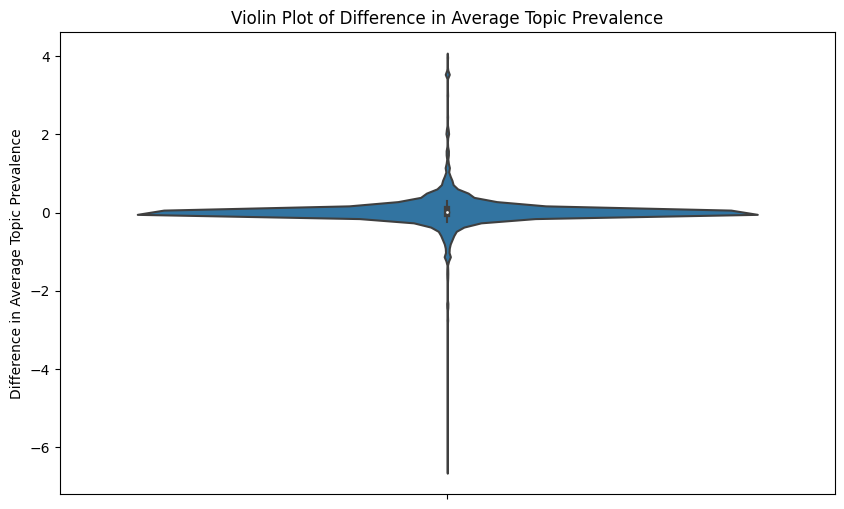

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y='difference_average_topic_prevalence', data=df_bertopic_kickstarter_technology_filtered)
plt.title('Violin Plot of Difference in Average Topic Prevalence')
plt.ylabel('Difference in Average Topic Prevalence')
plt.show()

## Games category

In [10]:
df_bertopic_kickstarter_games = df_bertopic_kickstarter.copy()

In [11]:
# Filter Dataframe by Games category (number 12)
df_bertopic_kickstarter_games = df_bertopic_kickstarter_games[(df_bertopic_kickstarter_games['project_category_id'] == 12) | (df_bertopic_kickstarter_games['project_parent_category_id'] == 12)]

In [12]:
docs_games = df_bertopic_kickstarter_games['project_description'].tolist()

In [13]:
from sentence_transformers import SentenceTransformer

# all-distilroberta-v1 512 token limit default is all-MiniLM-L6-v2 with 256 token limit
sentence_model_games = SentenceTransformer("all-distilroberta-v1")
embeddings_games = sentence_model_games.encode(docs_games, show_progress_bar=True)

Batches:   0%|          | 0/1119 [00:00<?, ?it/s]

In [14]:
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# Only Topics with 15 documents or more
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# removes noise
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=(['0000', 'with sound', 'play replay', 'replay with', 'capable browser', 'sound 0000', 'html5 capable', 'content play', '0000 0000', 'sound play']))

# removes stopwords and other extremes
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # vectorizer_model = CountVectorizer(stop_words="english") as an alternative to remove stopwords (does not remove other extremes)

topic_model_games = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, language="english", calculate_probabilities=True, verbose=True, n_gram_range=(1, 2)) #embedding_model=sentence_model
topics_games, probs_games = topic_model_games.fit_transform(docs_games, embeddings_games) #add embeddings as parameter to use costum embeddings model

2023-09-28 03:13:07,628 - BERTopic - Reduced dimensionality
2023-09-28 03:13:15,604 - BERTopic - Clustered reduced embeddings


In [15]:
freq = topic_model_games.get_topic_info(); freq.head(300)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,17913,-1_game_the game_as_that,"[game, the game, as, that, your, it, of the, o...",[What have game reviewers been saying about Ra...
1,0,2096,0_deck_playing cards_decks_tuck,"[deck, playing cards, decks, tuck, playing, ca...",[Once this Kickstarter is over we will be sell...
2,1,1452,1_miniatures_models_terrain_files,"[miniatures, models, terrain, files, 3d, minia...",[Help Make Some Miniatures!\n\nI need your hel...
3,2,931,2_zine_adventure_book_pdf,"[zine, adventure, book, pdf, adventures, pages...","[The Midderlands\n\nA green-hued, dark-fantasy..."
4,3,923,3_space_ships_planet_planets,"[space, ships, planet, planets, ship, galaxy, ...",[SD-01 SNEAK PEEK There's something myste...
...,...,...,...,...,...
66,65,44,65_railways_railways of_railroad_train,"[railways, railways of, railroad, train, locom...",[Build railroads through France and increase t...
67,66,43,66_basketball_hoops_hoop_rallyhoops,"[basketball, hoops, hoop, rallyhoops, sports, ...","[We are RallyHoops, the new patent-pending spo..."
68,67,42,67_evolution_species_ecosystem_igb,"[evolution, species, ecosystem, igb, clades, b...",[EKO: TCG is a trading card game about surviva...
69,68,40,68_werewolf_werewolves_villagers_moderator,"[werewolf, werewolves, villagers, moderator, t...",[Werewolf is a classic party game for friends ...


### Difference in Relative topic prevelance

In [ ]:
document_info_games = topic_model_games.get_document_info(docs_games)

In [ ]:
assign_topic_dist(df_bertopic_kickstarter_games, probs_games)

In [ ]:
for i, row in document_info_games.iterrows():
    df_bertopic_kickstarter_games.at[df_bertopic_kickstarter_games.index[i], "topic"] = row["Topic"]

In [ ]:
df_bertopic_kickstarter_games["year"] = pd.to_datetime(df_bertopic_kickstarter_games['project_launched_at']).dt.strftime('%Y')

In [ ]:
topic_df_games = calculate_relative_weighted_topic_prevelances_per_year(df_bertopic_kickstarter_games)

In [ ]:
calculate_difference_average_topic_prevelance_weighted(df_bertopic_kickstarter_games, topic_df_games)

In [ ]:
df_bertopic_kickstarter_games['difference_average_topic_prevalence'] = df_bertopic_kickstarter_games['difference_average_topic_prevalence'] * 100

In [ ]:
# Count of positive values
positive_count = (df_bertopic_kickstarter_games['difference_average_topic_prevalence'] > 0).sum()

# Count of negative values
negative_count = (df_bertopic_kickstarter_games['difference_average_topic_prevalence'] < 0).sum()

print(f'Number of positive values: {positive_count}')
print(f'Number of negative values: {negative_count}')

Number of positive values: 10741
Number of negative values: 7062


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y='difference_average_topic_prevalence', data=df_bertopic_kickstarter_games_filtered)
plt.title('Violin Plot of Difference in Average Topic Prevalence')
plt.ylabel('Difference in Average Topic Prevalence')
plt.show()

## Design category

In [16]:
df_bertopic_kickstarter_design = df_bertopic_kickstarter.copy()

In [17]:
# Filter Dataframe by Design category (number 7)
df_bertopic_kickstarter_design = df_bertopic_kickstarter_design[(df_bertopic_kickstarter_design['project_category_id'] == 7) | (df_bertopic_kickstarter_design['project_parent_category_id'] == 7)]

In [18]:
docs_design = df_bertopic_kickstarter_design['project_description'].tolist()

In [19]:
from sentence_transformers import SentenceTransformer

# all-distilroberta-v1 512 token limit default is all-MiniLM-L6-v2 with 256 token limit
sentence_model_design = SentenceTransformer("all-distilroberta-v1")
embeddings_design = sentence_model_design.encode(docs_design, show_progress_bar=True)

Batches:   0%|          | 0/855 [00:00<?, ?it/s]

In [20]:
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# Only Topics with 15 documents or more
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# removes noise
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=(['0000', 'with sound', 'play replay', 'replay with', 'capable browser', 'sound 0000', 'html5 capable', 'content play', '0000 0000', 'sound play']))

# removes stopwords and other extremes
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # vectorizer_model = CountVectorizer(stop_words="english") as an alternative to remove stopwords (does not remove other extremes)

topic_model_design = BERTopic(hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, language="english", calculate_probabilities=True, verbose=True, n_gram_range=(1, 2)) #embedding_model=sentence_model
topics_design, probs_design = topic_model_design.fit_transform(docs_design, embeddings_design) #add embeddings as parameter to use costum embeddings model

2023-09-28 03:17:52,226 - BERTopic - Reduced dimensionality
2023-09-28 03:18:00,267 - BERTopic - Clustered reduced embeddings


In [21]:
freq = topic_model_design.get_topic_info(); freq.head(300)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9570,-1_my_will_have_be,"[my, will, have, be, this, as, are, can, all, ...","[LAST DAY ON KICKSTARTER, so we thought we'd h..."
1,0,850,0_bag_backpack_bags_luggage,"[bag, backpack, bags, luggage, pack, travel, t...",[Choose from the following rewards. The APEX L...
2,1,626,1_wallet_wallets_cards_cash,"[wallet, wallets, cards, cash, the wallet, rfi...","[Unlike other thin wallets, Stealth Wallet was..."
3,2,597,2_dog_dogs_pet_cat,"[dog, dogs, pet, cat, leash, cats, your dog, p...",[The first PetWashSPA® paper model Pet...
4,3,594,3_fitness_workout_exercise_gym,"[fitness, workout, exercise, gym, muscles, tra...",[ .Brandon Curry - Heavy W...
...,...,...,...,...,...
93,92,46,92_streetzone_drivers_child_helmet,"[streetzone, drivers, child, helmet, safety, c...","[In recent years, there has been a movement ge..."
94,93,46,93_watch_apple watch_pebble_timedock,"[watch, apple watch, pebble, timedock, apple, ...",[TimeDock has successfully funded twice before...
95,94,43,94_reuleaux_cube_reuleaux triangle_puzzle,"[reuleaux, cube, reuleaux triangle, puzzle, co...",[Thank you Backers!!!\nIf you missed out on ou...
96,95,43,95_feeder_birds_feeders_chickens,"[feeder, birds, feeders, chickens, the feeder,...",[REFER 5 PEOPLE AND GET A SINGLE FREE! REFER 1...


### Difference in Relative topic prevelance

In [ ]:
document_info_design = topic_model_design.get_document_info(docs_design)

In [ ]:
assign_topic_dist(df_bertopic_kickstarter_design, probs_design)

In [ ]:
for i, row in document_info_design.iterrows():
    df_bertopic_kickstarter_design.at[df_bertopic_kickstarter_design.index[i], "topic"] = row["Topic"]

In [ ]:
df_bertopic_kickstarter_design["year"] = pd.to_datetime(df_bertopic_kickstarter_design['project_launched_at']).dt.strftime('%Y')

In [ ]:
topic_df_design = calculate_relative_weighted_topic_prevelances_per_year(df_bertopic_kickstarter_design)

In [ ]:
calculate_difference_average_topic_prevelance_weighted(df_bertopic_kickstarter_design, topic_df_design)

In [ ]:
df_bertopic_kickstarter_design['difference_average_topic_prevalence'] = df_bertopic_kickstarter_design['difference_average_topic_prevalence'] * 100

In [ ]:
# Count of positive values
positive_count = (df_bertopic_kickstarter_design['difference_average_topic_prevalence'] > 0).sum()

# Count of negative values
negative_count = (df_bertopic_kickstarter_design['difference_average_topic_prevalence'] < 0).sum()

print(f'Number of positive values: {positive_count}')
print(f'Number of negative values: {negative_count}')

Number of positive values: 10263
Number of negative values: 8090


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y='difference_average_topic_prevalence', data=df_bertopic_kickstarter_filtered)
plt.title('Violin Plot of Difference in Average Topic Prevalence')
plt.ylabel('Difference in Average Topic Prevalence')
plt.show()

# OLS Regression

## Technology

In [ ]:
# Filter outlier topics
df_bertopic_kickstarter_technology_filtered = df_bertopic_kickstarter_technology[df_bertopic_kickstarter_technology["topic"] != -1]

In [ ]:
!pip install statsmodels
import statsmodels.api as sm
import numpy as np
from datetime import datetime

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Setting up Model Variables by transforming Data Columns
df_bertopic_kickstarter_technology_filtered['project_launched_at'] = pd.to_datetime(df_bertopic_kickstarter_technology_filtered['project_launched_at'])
df_bertopic_kickstarter_technology_filtered['project_deadline'] = pd.to_datetime(df_bertopic_kickstarter_technology_filtered['project_deadline'])
df_bertopic_kickstarter_technology_filtered['month'] = pd.to_datetime(df_bertopic_kickstarter_technology_filtered['project_launched_at']).dt.month
df_bertopic_kickstarter_technology_filtered['timestamp_launched'] = df_bertopic_kickstarter_technology_filtered['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_bertopic_kickstarter_technology_filtered['timestamp_deadline'] = df_bertopic_kickstarter_technology_filtered['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))

## Response Variable
CF_success = df_bertopic_kickstarter_technology_filtered['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)
CF_success = CF_success.apply(lambda x: 0 if pd.isna(x) else x)

## Explanatory Variables
difference_average_topic_prevalence = df_bertopic_kickstarter_technology_filtered['difference_average_topic_prevalence']

##Control Variables
loved_project = df_bertopic_kickstarter_technology_filtered['project_staff_pick']
video = df_bertopic_kickstarter_technology_filtered['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_bertopic_kickstarter_technology_filtered['timestamp_deadline'] - df_bertopic_kickstarter_technology_filtered['timestamp_launched']
number_of_words = df_bertopic_kickstarter_technology_filtered['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_bertopic_kickstarter_technology_filtered['project_goal'].apply(lambda x: np.log(x))
updates = df_bertopic_kickstarter_technology_filtered['updates_until_deadline']
rewards = df_bertopic_kickstarter_technology_filtered['project_rewards']
number_projects = df_bertopic_kickstarter_technology_filtered['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
month_dummies = pd.get_dummies(df_bertopic_kickstarter_technology_filtered['month'], prefix='month', drop_first=True)
#year_dummies = pd.get_dummies(df_kickstarter['Year'], prefix='year', drop_first=True)

In [ ]:
# Create a new DataFrame to store the variables
df_model_technology = pd.DataFrame({
    'Difference in average topic prevalence': difference_average_topic_prevalence,
    #'Difference in average topic prevalence^2': difference_average_topic_prevalence * difference_average_topic_prevalence,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Days': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of prior projects': number_projects
})
# Concatenate the dummy variables
df_model_technology = pd.concat([df_model_technology, month_dummies], axis=1)

X_technology = df_model_technology
# Add a constant (intercept) to the feature matrix
X_technology_with_intercept = sm.add_constant(X_technology)

# Fit for model without time
model_technology_2 = sm.OLS(CF_success, X_technology_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_technology.summary())

## Games

In [ ]:
# Filter outlier topics
df_bertopic_kickstarter_games_filtered = df_bertopic_kickstarter_games[df_bertopic_kickstarter_games["topic"] != -1]

In [ ]:
# Setting up Model Variables by transforming Data Columns
df_bertopic_kickstarter_games_filtered['project_launched_at'] = pd.to_datetime(df_bertopic_kickstarter_games_filtered['project_launched_at'])
df_bertopic_kickstarter_games_filtered['project_deadline'] = pd.to_datetime(df_bertopic_kickstarter_games_filtered['project_deadline'])
df_bertopic_kickstarter_games_filtered['month'] = pd.to_datetime(df_bertopic_kickstarter_games_filtered['project_launched_at']).dt.month
df_bertopic_kickstarter_games_filtered['timestamp_launched'] = df_bertopic_kickstarter_games_filtered['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_bertopic_kickstarter_games_filtered['timestamp_deadline'] = df_bertopic_kickstarter_games_filtered['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))

## Response Variable
CF_success = df_bertopic_kickstarter_games_filtered['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)
CF_success = CF_success.apply(lambda x: 0 if pd.isna(x) else x)

## Explanatory Variables
difference_average_topic_prevalence = df_bertopic_kickstarter_games_filtered['difference_average_topic_prevalence']

##Control Variables
loved_project = df_bertopic_kickstarter_games_filtered['project_staff_pick']
video = df_bertopic_kickstarter_games_filtered['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_bertopic_kickstarter_games_filtered['timestamp_deadline'] - df_bertopic_kickstarter_games_filtered['timestamp_launched']
number_of_words = df_bertopic_kickstarter_games_filtered['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_bertopic_kickstarter_games_filtered['project_goal'].apply(lambda x: np.log(x))
updates = df_bertopic_kickstarter_games_filtered['updates_until_deadline']
rewards = df_bertopic_kickstarter_games_filtered['project_rewards']
number_projects = df_bertopic_kickstarter_games_filtered['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
month_dummies = pd.get_dummies(df_bertopic_kickstarter_games_filtered['month'], prefix='month', drop_first=True)
#year_dummies = pd.get_dummies(df_kickstarter['Year'], prefix='year', drop_first=True)

In [ ]:
# Create a new DataFrame to store the variables
df_model_games = pd.DataFrame({
    'Difference in average topic prevalence': difference_average_topic_prevalence,
    #'Difference in average topic prevalence^2': difference_average_topic_prevalence * difference_average_topic_prevalence,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Days': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of prior projects': number_projects
})
# Concatenate the dummy variables
df_model_games = pd.concat([df_model_games, month_dummies], axis=1)

X_games = df_model_games
# Add a constant (intercept) to the feature matrix
X_games_with_intercept = sm.add_constant(X_games)

# Fit for model without time
model_games2 = sm.OLS(CF_success, X_games_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_games.summary())

## Design

In [ ]:
# Filter outlier topics
df_bertopic_kickstarter_design_filtered = df_bertopic_kickstarter_design[df_bertopic_kickstarter_design["topic"] != -1]

In [ ]:
# Setting up Model Variables by transforming Data Columns
df_bertopic_kickstarter_design_filtered['project_launched_at'] = pd.to_datetime(df_bertopic_kickstarter_design_filtered['project_launched_at'])
df_bertopic_kickstarter_design_filtered['project_deadline'] = pd.to_datetime(df_bertopic_kickstarter_design_filtered['project_deadline'])
df_bertopic_kickstarter_design_filtered['month'] = pd.to_datetime(df_bertopic_kickstarter_design_filtered['project_launched_at']).dt.month
df_bertopic_kickstarter_design_filtered['timestamp_launched'] = df_bertopic_kickstarter_design_filtered['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_bertopic_kickstarter_design_filtered['timestamp_deadline'] = df_bertopic_kickstarter_design_filtered['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))

## Response Variable
CF_success = df_bertopic_kickstarter_design_filtered['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)
CF_success = CF_success.apply(lambda x: 0 if pd.isna(x) else x)

## Explanatory Variables
difference_average_topic_prevalence = df_bertopic_kickstarter_design_filtered['difference_average_topic_prevalence']

##Control Variables
loved_project = df_bertopic_kickstarter_design_filtered['project_staff_pick']
video = df_bertopic_kickstarter_design_filtered['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_bertopic_kickstarter_design_filtered['timestamp_deadline'] - df_bertopic_kickstarter_design_filtered['timestamp_launched']
number_of_words = df_bertopic_kickstarter_design_filtered['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_bertopic_kickstarter_design_filtered['project_goal'].apply(lambda x: np.log(x))
updates = df_bertopic_kickstarter_design_filtered['updates_until_deadline']
rewards = df_bertopic_kickstarter_design_filtered['project_rewards']
number_projects = df_bertopic_kickstarter_design_filtered['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
month_dummies = pd.get_dummies(df_bertopic_kickstarter_design_filtered['month'], prefix='month', drop_first=True)
#year_dummies = pd.get_dummies(df_kickstarter['Year'], prefix='year', drop_first=True)

In [ ]:
# Create a new DataFrame to store the variables
df_model_design = pd.DataFrame({
    'Difference in average topic prevalence': difference_average_topic_prevalence,
    #'Difference in average topic prevalence^2': difference_average_topic_prevalence * difference_average_topic_prevalence,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Days': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of prior projects': number_projects
})
# Concatenate the dummy variables
df_model_design = pd.concat([df_model_design, month_dummies], axis=1)

X_design = df_model_design
# Add a constant (intercept) to the feature matrix
X_design_with_intercept = sm.add_constant(X_design)

# Fit for model without time
model_design2 = sm.OLS(CF_success, X_design_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_design.summary())

# Latex table Regression

In [130]:
from statsmodels.iolib.summary2 import summary_col

# Assuming reg0, reg1, reg2 are your regression models

# Extract information for each model
info_dict = {
    'AIC': lambda x: f"{x.aic:.0f}",
    'BIC': lambda x: f"{x.bic:.0f}",
    'N':lambda x: "{0:d}".format(int(x.nobs)),
    #'Cond. No.': lambda x: f"{x.condition_number:.2f}"
}

# Select the variables you want to include in the summary (excluding dummy variables)
included_variables = ['Difference in average topic prevalence', 'Difference in average topic prevalence^2',
                      'Loved Project', 'Video', 'Funding Duration', 'Log(Number of Words)', 'Log(Funding Goal)', 'Updates', 'Rewards', 'Number of projects']  # Add the variables you want to include

# Create a summary table for the selected variables
summary = summary_col(
    [model_technology_1, model_technology_2, model_games1, model_games2, model_design1, model_design2],
    model_names=['Technology Category','Technology Category', 'Games Category', 'Games Category','Design Category', 'Design Category'], 
    stars=True, 
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=included_variables  # Specify the order of regressors in the table
)

# Print the customized summary table
print(summary)

latex_table = summary.as_latex() 



                                         Technology Category I Technology Category II Games Category I Games Category II Design Category I Design Category II
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Difference in average topic prevalence   0.102**               0.077                  0.366***         0.464***          0.054*            0.073**           
                                         (0.052)               (0.059)                (0.060)          (0.063)           (0.030)           (0.033)           
Difference in average topic prevalence^2                       0.048*                                  -0.079***                           -0.009            
                                                               (0.025)                                 (0.024)                             (0.008)           
Loved Project                            1.830***  

In [ ]:
print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hline
                                         & Technology Category I & Technology Category II & Games Category I & Games Category II & Design Category I & Design Category II  \\
\hline
Difference in average topic prevalence   & 0.102**               & 0.077                  & 0.366***         & 0.464***          & 0.054*            & 0.073**             \\
                                         & (0.052)               & (0.059)                & (0.060)          & (0.063)           & (0.030)           & (0.033)             \\
Difference in average topic prevalence^2 &                       & 0.048*                 &                  & -0.079***         &                   & -0.009              \\
                                         &                       & (0.025)                &                  & (0.024)           &                   & (0.008)             \\
Loved Project                            &

# Latex table topic representations

In [54]:
freq_technology = topic_model_technology.get_topic_info(); 
freq_technology.drop(columns=['Name', 'Representative_Docs'], axis=1, inplace=True)
freq_technology = freq_technology.head(16)
with pd.option_context("max_colwidth", 1000):
    latex_table_tech = freq_technology.to_latex(index=False)

In [55]:
freq_games = topic_model_games.get_topic_info(); 
freq_games.drop(columns=['Name', 'Representative_Docs'], axis=1, inplace=True)
freq_games = freq_games.head(16)
with pd.option_context("max_colwidth", 1000):
    latex_table_games = freq_games.to_latex(index=False)

In [56]:
freq_design = topic_model_design.get_topic_info(); 
freq_design.drop(columns=['Name', 'Representative_Docs'], axis=1, inplace=True)
freq_design = freq_design.head(16)
with pd.option_context("max_colwidth", 1000):
    latex_table_design = freq_design.to_latex(index=False)

In [59]:
print(latex_table_design)

\begin{tabular}{rrl}
\toprule
 Topic &  Count &                                                                                     Representation \\
\midrule
    -1 &   9570 &                                              [my, will, have, be, this, as, are, can, all, of the] \\
     0 &    850 &                      [bag, backpack, bags, luggage, pack, travel, the bag, pockets, pocket, carry] \\
     1 &    626 &                   [wallet, wallets, cards, cash, the wallet, rfid, wallet is, slim, card, leather] \\
     2 &    597 &                                 [dog, dogs, pet, cat, leash, cats, your dog, pets, litter, collar] \\
     3 &    594 &       [fitness, workout, exercise, gym, muscles, training, resistance, muscle, exercises, posture] \\
     4 &    549 &                                   [my, business, website, am, me, logo, money, would, of my, have] \\
     5 &    494 &              [house, building, community, tiny, tiny house, park, land, build, property, historic] \\
 